In [87]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

# 🔹 1) 원본 데이터 읽기
flights_df = pd.read_csv('../data/Clean_Dataset.csv')
hotels_df   = pd.read_csv('../data/hotel_bookings.csv')

print("=== Flights columns ===")
print(flights_df.columns)
print("\n=== Hotels columns ===")
print(hotels_df.columns)

=== Flights columns ===
Index(['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city',
       'class', 'duration', 'days_left', 'price'],
      dtype='object')

=== Hotels columns ===
Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies',
       'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type',
       'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'reservation_status', 'reservation_status_date'],
      dtype='object')


In [85]:
## --- 항공편 데이터 클리닝 및 전처리 ---

# 1. 불필요한 인덱스 컬럼 제거
# 'Unnamed: 0' 또는 'flight'과 같이 데이터 고유 인덱스 역할을 하는 컬럼 제거
flights_df = flights_df.drop(['Unnamed: 0', 'flight'], axis=1, errors='ignore')

# 2. 가격(price) 이상치 처리
# 가격이 0이거나, 극단적으로 높은 값(예: 상위 1% 이상)은 제거하거나 한계치를 설정합니다.
# 여기서는 price가 150000 이하인 데이터만 남깁니다. (실제 데이터 분포에 따라 값은 조정 가능)
flights_df = flights_df[flights_df['price'] > 0]
flights_df = flights_df[flights_df['price'] <= 150000]

# 3. 데이터 타입 및 결측치 확인
# 범주형(object) 컬럼의 결측값은 'Unknown'으로 대체 (머신러닝 전처리 시 오류 방지)
for col in flights_df.select_dtypes(include='object').columns:
    if flights_df[col].isnull().any():
        flights_df[col] = flights_df[col].fillna('Unknown')

print("✅ 항공편 데이터 클리닝 완료.")
print(f"최종 flights_df 행/열: {flights_df.shape}")

✅ 항공편 데이터 클리닝 완료.
최종 flights_df 행/열: (300153, 10)


In [88]:
## --- 호텔 데이터 클리닝 및 전처리 ---

# 1. 취소된 예약 제거 (실제 발생한 여행만 분석)
# 'is_canceled' 컬럼이 0인 행만 남깁니다.
hotels_df = hotels_df[hotels_df['is_canceled'] == 0]

# 2. 총 숙박 일수(total_stays) 계산 및 0일 숙박 제거
# 주말(weekend)과 주중(week) 숙박 일수를 합산하여 'total_stays' 생성
hotels_df['total_stays'] = hotels_df['stays_in_weekend_nights'] + hotels_df['stays_in_week_nights']
hotels_df = hotels_df[hotels_df['total_stays'] > 0] # 숙박 일수가 0일인 행 제거

# 3. 평균 1박 요금(adr) 이상치 및 0값 처리
# adr이 0이거나, 극단적으로 높은 값(예: 상위 1% 이상)은 제거하거나 한계치를 설정합니다.
# 여기서는 0 제거 및 adr이 500 이하인 데이터만 남깁니다. (실제 데이터 분포에 따라 값은 조정 가능)
hotels_df = hotels_df[hotels_df['adr'] > 0]
hotels_df = hotels_df[hotels_df['adr'] <= 500]

# 4. 분석에 불필요한 컬럼 제거
# 예시: 'company', 'agent' 등 결측치가 많거나 분석 목표에 직접적인 관련이 적은 컬럼 제거
# 단, 'country', 'children' 등은 분석에 유용할 수 있으므로 남겨둡니다.
hotels_df = hotels_df.drop(['company', 'agent', 'is_canceled'], axis=1, errors='ignore')

print("✅ 호텔 데이터 클리닝 완료.")
print(f"최종 hotels_df 행/열: {hotels_df.shape}")

✅ 호텔 데이터 클리닝 완료.
최종 hotels_df 행/열: (73417, 30)


In [89]:
# 1. 여행 경로별 항공편 가격 통계 (GroupBy 1)
route_price_stats = flights_df.groupby(['source_city', 'destination_city'])['price'].agg(
    Avg_Price = 'mean',
    Min_Price = 'min',
    Price_Std = 'std'
).sort_values(by='Avg_Price', ascending=False)

print("--- 1. 경로별 평균 항공편 가격 분석 (상위 5개 경로) ---")
print(route_price_stats.head())

--- 1. 경로별 평균 항공편 가격 분석 (상위 5개 경로) ---
                                 Avg_Price  Min_Price     Price_Std
source_city destination_city                                       
Chennai     Bangalore         25081.850454       1443  23405.422526
Kolkata     Chennai           23660.361040       2966  23371.419897
Bangalore   Kolkata           23500.061229       3026  24631.108723
            Chennai           23321.850078       1603  22573.185689
Mumbai      Bangalore         23147.873807       2074  25900.493645


In [90]:
# 2. 도착 월별 호텔 예약 통계 (GroupBy 2)
# 월 이름을 순서대로 정렬하기 위한 사전 작업 (필수 아님, 시각화 시 유리)
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

monthly_hotel_stats = hotels_df.groupby('arrival_date_month')['adr'].agg(
    Avg_ADR = 'mean',
    Booking_Count = 'count',
    Max_ADR = 'max'
).reindex(month_order).dropna() # reindex로 월 순서 정리

print("\n--- 2. 월별 호텔 1박 평균 요금 분석 (계절성) ---")
print(monthly_hotel_stats)


--- 2. 월별 호텔 1박 평균 요금 분석 (계절성) ---
                       Avg_ADR  Booking_Count  Max_ADR
arrival_date_month                                    
January              68.941171           4006   284.20
February             74.172959           5245   284.20
March                79.009024           6504   285.00
April                99.638406           6449   336.00
May                 107.227510           6951   335.00
June                116.555278           6296   333.67
July                131.717846           7767   397.38
August              144.685018           8483   426.25
September           109.556734           6259   345.00
October              89.336903           6720   300.00
November             72.699217           4531   260.00
December             82.729275           4206   451.50


In [91]:
# 3. 좌석 등급별 항공편 가격 통계 (GroupBy 3)
class_price_stats = flights_df.groupby('class')['price'].agg(
    Avg_Price = 'mean',
    Median_Price = 'median',
    Count = 'size'
).sort_values(by='Avg_Price', ascending=False)

print("\n--- 3. 좌석 등급별 평균 항공편 가격 분석 ---")
print(class_price_stats)


--- 3. 좌석 등급별 평균 항공편 가격 분석 ---
             Avg_Price  Median_Price   Count
class                                       
Business  52540.081124       53164.0   93487
Economy    6572.342383        5772.0  206666


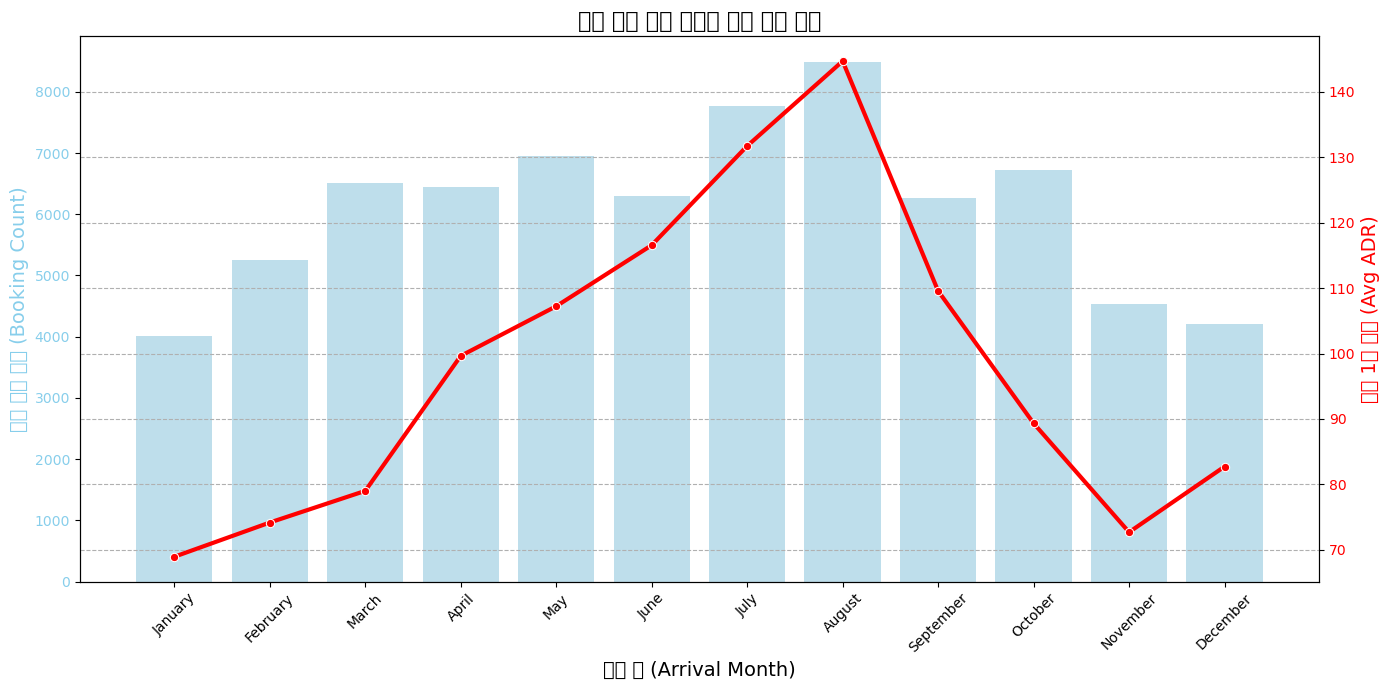

In [94]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Matplotlib figure와 첫 번째 축(Average ADR) 설정
fig, ax1 = plt.subplots(figsize=(14, 7))

# 막대 그래프 (Booking Count)
sns.barplot(x=monthly_hotel_stats.index, y='Booking_Count', data=monthly_hotel_stats, 
            color='skyblue', alpha=0.6, ax=ax1)
ax1.set_xlabel('도착 월 (Arrival Month)', fontsize=14)
ax1.set_ylabel('호텔 예약 건수 (Booking Count)', color='skyblue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.tick_params(axis='x', rotation=45) # 월 이름을 45도 회전하여 겹치지 않게 표시

# 2. 두 번째 축 (Average ADR) 설정
ax2 = ax1.twinx() 

# 라인 그래프 (Average ADR)
sns.lineplot(x=monthly_hotel_stats.index, y='Avg_ADR', data=monthly_hotel_stats, 
             color='red', marker='o', linewidth=3, ax=ax2)
ax2.set_ylabel('평균 1박 요금 (Avg ADR)', color='red', fontsize=14)
ax2.tick_params(axis='y', labelcolor='red')

plt.title('월별 호텔 예약 건수와 평균 요금 변화', fontsize=16)
fig.tight_layout() 
plt.grid(axis='y', linestyle='--')
plt.show()

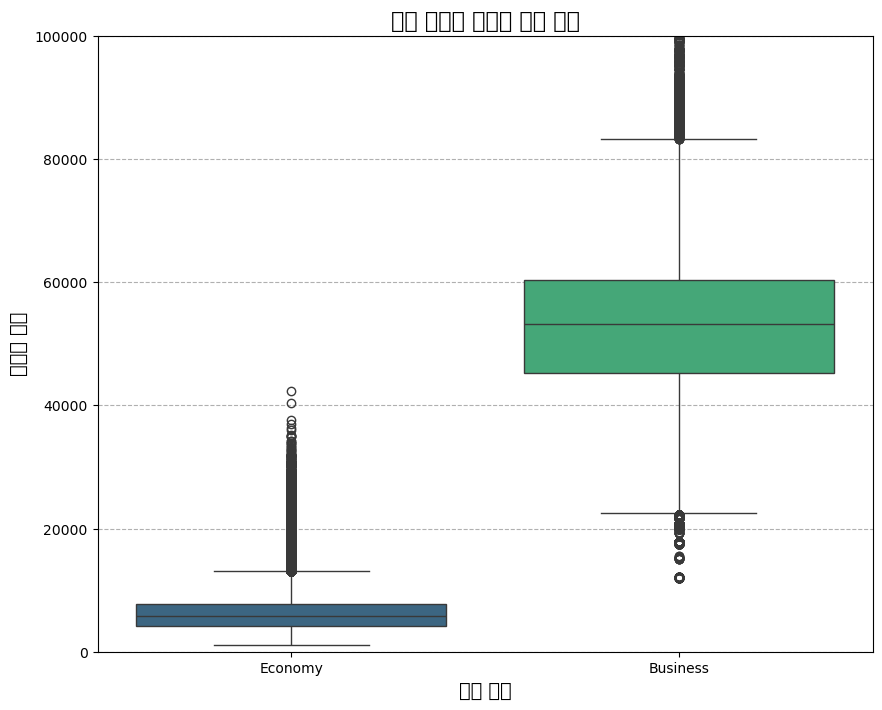

In [95]:
import warnings
warnings.filterwarnings('ignore')
# 1. 좌석 등급 순서 정의 (예상 가격 순서)
class_order = ['Economy', 'Business', 'First'] 
# 실제 데이터의 등급 이름에 맞게 수정해야 합니다. 
# 현재 'Clean_Dataset.csv'에 'Business'와 'Economy'만 있는 것으로 보이므로 두 가지만 사용합니다.
class_order = ['Economy', 'Business'] 

plt.figure(figsize=(10, 8))
sns.boxplot(x='class', y='price', data=flights_df, 
            order=class_order, palette='viridis')

plt.title('좌석 등급별 항공편 가격 분포', fontsize=16)
plt.xlabel('좌석 등급', fontsize=14)
plt.ylabel('항공편 가격', fontsize=14)
plt.ylim(0, 100000) # 가격 범위를 지정하여 이상치 제외 (시각적 명료성 확보)
plt.grid(axis='y', linestyle='--')
plt.show()

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. 머신러닝에 사용할 데이터셋 준비 (flights_df)
ml_df = flights_df.copy() # 원본 보존 및 Warning 방지

# 2. 범주형 데이터 인코딩 (One-Hot Encoding)
# 'airline', 'source_city', 'destination_city', 'class', 'stops', 'departure_time', 'arrival_time'
# 이 컬럼들이 실제 flights_df에 있다고 가정하고 진행합니다.
categorical_cols = ['airline', 'source_city', 'destination_city', 'class', 'stops', 'departure_time', 'arrival_time']
ml_df = pd.get_dummies(ml_df, columns=[col for col in categorical_cols if col in ml_df.columns])

# 3. 불필요한 컬럼 제거
# 'flight' (고유값이 너무 많음), 'duration' (price와 높은 상관관계로 예측력이 과도해질 수 있음)
# 가격 예측에 사용하지 않을 컬럼은 제외
X = ml_df.drop(['price', 'flight', 'duration'], axis=1, errors='ignore')

# 4. 타겟 변수 (y) 설정
y = ml_df['price']

# 5. 데이터 분할: 학습용(80%)과 테스트용(20%)으로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ 머신러닝 데이터 준비 완료.")
print(f"학습 데이터 크기 (Features): {X_train.shape}")

✅ 머신러닝 데이터 준비 완료.
학습 데이터 크기 (Features): (240122, 37)


In [97]:
# 1. 모델 선택 및 학습 (Random Forest Regressor)
print("⏳ 모델 학습 시작...")
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15)
model.fit(X_train, y_train)

# 2. 테스트 데이터로 예측
y_pred = model.predict(X_test)

# 3. 모델 평가 수치 계산 (필수 수행 요소)
# 평균 제곱 오차 (MSE: Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
# 결정계수 (R2 Score: Coefficient of Determination)
r2 = r2_score(y_test, y_pred)
# 제곱근 평균 제곱 오차 (RMSE: Root Mean Squared Error)
rmse = np.sqrt(mse)

print("✅ 모델 학습 완료 및 평가 수치 계산 완료.")
print(f"\n--- 항공편 가격 예측 모델 평가 수치 ---")
print(f"평균 제곱 오차 (MSE): {mse:.2f}")
print(f"제곱근 오차 (RMSE): {rmse:.2f}")
print(f"결정계수 (R-squared): {r2:.4f} (1에 가까울수록 성능 우수)")

⏳ 모델 학습 시작...
✅ 모델 학습 완료 및 평가 수치 계산 완료.

--- 항공편 가격 예측 모델 평가 수치 ---
평균 제곱 오차 (MSE): 14575738.37
제곱근 오차 (RMSE): 3817.82
결정계수 (R-squared): 0.9717 (1에 가까울수록 성능 우수)


In [98]:
import pandas as pd

# Pandas Excel Writer 객체 생성: 하나의 파일에 여러 시트를 작성할 수 있게 해줍니다.
# 파일 이름은 'Analysis_Results.xlsx'로 저장됩니다.
excel_writer = pd.ExcelWriter('Analysis_Results.xlsx', engine='xlsxwriter')

# 1. 경로별 가격 통계 저장 (시트: Route_Price)
# 'route_price_stats'는 이전에 GroupBy 1에서 생성된 데이터프레임입니다.
route_price_stats.to_excel(excel_writer, sheet_name='Route_Price_Stats')

# 2. 월별 호텔 통계 저장 (시트: Monthly_Hotel)
# 'monthly_hotel_stats'는 이전에 GroupBy 2에서 생성된 데이터프레임입니다.
monthly_hotel_stats.to_excel(excel_writer, sheet_name='Monthly_Hotel_Stats')

# 3. 좌석 등급별 가격 통계 저장 (시트: Class_Price)
# 'class_price_stats'는 이전에 GroupBy 3에서 생성된 데이터프레임입니다.
class_price_stats.to_excel(excel_writer, sheet_name='Class_Price_Stats')

# 4. 저장 완료 및 닫기
excel_writer.close()
print("✅ 모든 분석 결과가 'Analysis_Results.xlsx' 파일에 시트별로 저장되었습니다.")

ModuleNotFoundError: No module named 'xlsxwriter'